# Secular dynamics with celmech
This notebook shows how to use celmech to integrate a system of secular equations of motion.

Import packages

In [1]:
from celmech.disturbing_function import *
from sympy import symbols, init_printing,Function,simplify,collect,cos
init_printing()
import numpy as np
from celmech.poincare import Poincare, PoincareHamiltonian
import matplotlib
%matplotlib inline

## Use celmech to derive a 4th order Laplace expansion of the secular disturbing function:

Use sympy to define symbolic variables:

In [2]:
e1,e2,w1,w2=symbols("e1 e2 varpi1 varpi2")
e1,e2,w1,w2

Use celmech to get an expression for the disturbing function in terms of symbolic variables

In [3]:
sdf4 = secular_DF(e1,e2,w1,w2,2)
# print the expression
sdf4

## Use sympy to evaluate disturbing function for a choice of semi-major axis ratio.

celmech uses the 'laplace_B'  routine to get numerical values of Laplace coefficients:

In [4]:
Nalpha = 0.4
sdf4.subs([(S('alpha'),Nalpha),(Function('b'),laplace_B)])

# Compare N-body with celmech 

## Set up a Rebound integration

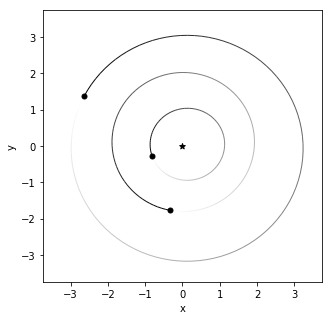

In [5]:
np.random.seed(123)
import rebound
def make_sim(pratio1,pratio2):
    mass = 3.e-5
    
    e1,e2,e3 = 0.2 * np.random.rand(3) 
    w1,w2,w3 = 2*np.pi*np.random.rand(3)
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2

    sim.add(m=1.)
    sim.add(m=mass, e=e1, P=1.,pomega=w1)
    sim.add(m=mass, e=e2, P=pratio1, pomega=w2)
    sim.add(m=mass, e=e3, P=pratio1*pratio2, pomega=w3)
    
    sim.move_to_com()
    return sim     

sim=make_sim(np.sqrt(7),np.sqrt(4.3))
sim.integrator='whfast'
sim.dt=sim.particles[1].P / 25.

rebound.plotting.OrbitPlot(sim);

## Use Rebound simulation to initalize celmech system in Poincare variables

In [6]:
pvars = Poincare.from_Simulation(sim)
Hsim = PoincareHamiltonian(pvars)

## Add secular disturbing function terms to 4th order

Secular terms are added for each pairwise interaction

In [7]:
Nbodies = Hsim.state.N
expand_order=4
for i in range(1,Nbodies):
    for j in range(i+1,Nbodies):
        Hsim.add_secular_terms(i,j,expand_order)

Computing secular expansion to order 4...


Set secular mode disables (Lambda,lambda) degrees of freedom in Hamiltonian by replacing the $\Lambda_i$'s with constant values

In [8]:
Hsim.set_secular_mode()

## Run the integrations

In [9]:
tFin,Nout= 4e5,500
times= np.linspace(0,tFin,Nout)
rebound_ecc = np.zeros((3,Nout))
celmech_ecc = np.zeros((3,Nout))
for i,t in enumerate(times):
    for j in range(1,sim.N):
        celmech_ecc[j-1,i] = Hsim.state.particles[j].e
        rebound_ecc[j-1,i] = sim.particles[j].e
    Hsim.integrate(t)
    sim.integrate(t)

## Compare results

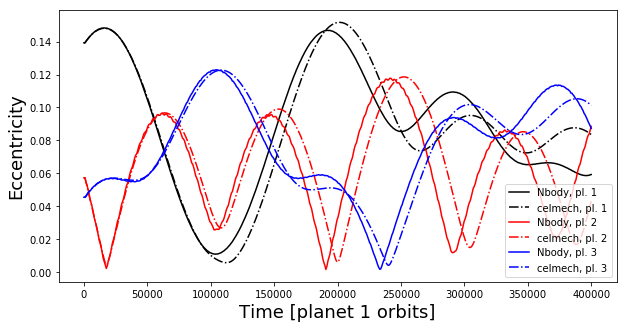

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,figsize=(10,5))
for i,col in enumerate(['k','r','b']):
    ax.plot(times,rebound_ecc[i],'%s'%col,label='Nbody, pl. %d'%(i+1))
    ax.plot(times,celmech_ecc[i],'%s-.'%col,label='celmech, pl. %d'%(i+1))

ax.set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax.set_ylabel('Eccentricity',fontsize=18)
ax.legend()